<a href="https://colab.research.google.com/github/wespitia9/Text-Mining-con-Python-Un-enfoque-pr-ctico/blob/main/Text_Mining_con_Python_Un_enfoque_pr%C3%A1ctico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Este paso a paso tiene como objetivo proporcionar una introducción al análisis de texto (text mining) utilizando `Python`. Para ello, se analizarán las publicaciones realizadas en Twitter por diversas personalidades, con el propósito de y busqueda de:


*   Analizar y obervar sentimientos y emociones que posiblemente se puedan identificar
*   Identificación y/o reconocimiento de palabras claves empleadas
*   Creación de modelo de `Machine Learning` para clasificación de autoría por publicaciones

Con base a lo anterior, aplicaremos la analítica de texto, y empezemos por definirla


La analítica de texto, también conocida como minería de texto o text mining, se refiere a un conjunto de técnicas que tienen como finalidad estructurar la información heterogénea presente en los textos para identificar patrones, como el uso de palabras, y extraer nueva información. En otras palabras, se trata de un proceso que permite explorar grandes cantidades de datos no estructurados y transformarlos en conocimiento útil para la toma de decisiones y la mejora de procesos.

Actualmente, Twitter se ha consolidado como una fuente dinámica e ingente de contenidos que resulta de gran importancia para los estudios de Social Media Analytics debido a su popularidad e impacto en la sociedad. Dicha plataforma se ha convertido en la principal fuente de información para analizar la reputación de empresas, productos o personalidades, estudios de impacto de marketing, extracción de opiniones y predicción de tendencias, entre otras aplicaciones. En definitiva, Twitter se ha posicionado como una herramienta clave para obtener información valiosa y tomar decisiones informadas en el ámbito empresarial y social.

# Extracción de datos de Twitter mediante técnicas de minería de datos.

Al igual que sucede en muchas redes sociales, Twitter ofrece a los usuarios una API que les permite acceder y extraer información. Aunque en la mayoría de los casos se trata de web services API, en ocasiones se encuentran librerías que permiten interactuar con la API desde diferentes lenguajes de programación. Un ejemplo de estas librerías es [Tweepy](https://docs.tweepy.org/en/latest/index.html), un wrapper (`En lenguajes de programación como JavaScript, un wrapper o envoltorio es una función que llama a una o varias funciones, unas veces únicamente por convenio y otras para adaptarlas con el objetivo de hacer una tarea ligeramente diferente. Por ejemplo, las librerías SDK de AWS son un ejemplo de wrappers.`) de Python que se comunica con la API de Twitter.

Dado que las APIs suelen actualizarse con cierta frecuencia, para evitar que el código mostrado en el documento se vuelva obsoleto, se utilizarán tweets previamente extraídos que se encuentran disponibles en el repositorio de [GitHub](https://github.com/JoaquinAmatRodrigo/Estadistica-con-R/tree/master/datos). En concreto, los tweets seleccionados corresponden a:



*   Elon Musk (@elonmusk) | Lider empresarial de la industria tecnológica.
*   Bill Gates (@BillGates) | Lider empresarial de la industria tecnológica.
*   Ed Lee (@mayoredlee) | exalcalde de la ciudad de San Francisco.

# Configuración de las herramientas de trabajo

## Librerias recomendadas para el desarrollo de este ejercicio.

In [1]:
# Librerias recomendadas para la manipulación de datos

import numpy as np
import pandas as pd
import string
import re

# Librerias recomendadas para la implementación de gráficos

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Librerias recomendadas para el preprocesado y modelado de datos

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

## Adquisición de datos mediante técnicas de extracción y recolección de información.

NOTA: Los datos utilizados en este documento corresponden a tweets publicados por Elon Musk (@elonmusk), Bill Gates (@BillGates) y el exalcalde de San Francisco Ed Lee (@mayoredlee). Estos tweets fueron extraídos en noviembre de 2017.

In [2]:
# Proceso de lectura y carga de datos

url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('Número de tweets de Bill Gates: ' + str(tweets_bgates.shape[0]))
print('Número de tweets de Ed Lee: ' + str(tweets_edlee.shape[0]))
print('Número de tweets de Elon Musk: ' + str(tweets_elon.shape[0]))

Número de tweets de Bill Gates: 2087
Número de tweets de Ed Lee: 2447
Número de tweets de Elon Musk: 2678


In [3]:
# Se combinan los dos dataframes en uno solo
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Se seleccionan y renombran las columnas relevantes
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Conversión a formato de fecha
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6


# Análisis de la distribución temporal de los tweets.

Cada usuario pudo haber comenzado a utilizar Twitter en momentos diferentes, es importante explorar si los tweets recuperados se `solapan` en el tiempo.

Se hace referencia a `solapan` cuando hay una superposición o coincidencia de dos o más elementos en el mismo periodo de tiempo. En el contexto de los tweets recuperados, se refiere a la posibilidad de que los tweets de los usuarios en cuestión se hayan publicado en el mismo periodo de tiempo, lo que puede tener implicaciones en el análisis y las conclusiones obtenidas a partir de ellos.

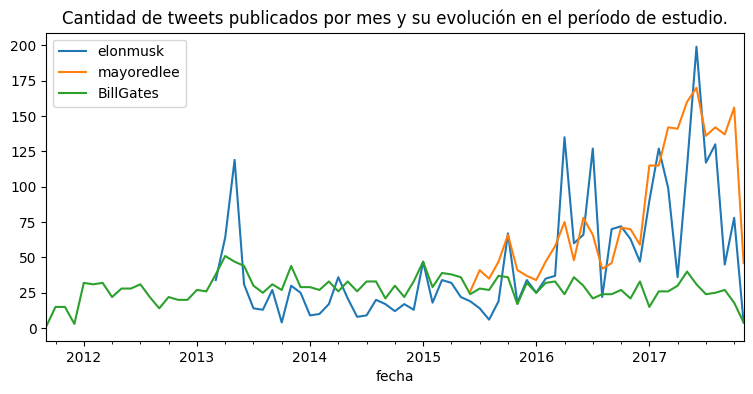

In [5]:
# Análisis de la distribución temporal de los tweets y su relación con los eventos relevantes en el período de estudio.

fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Cantidad de tweets publicados por mes y su evolución en el período de estudio.')
ax.legend();

## Observaciones importantes que pueden inferir del análisis de la distribución temporal:



Tras el análisis de la distribución temporal de los tweets de los usuarios seleccionados, se observa un perfil de actividad distinto para cada uno de ellos.

*   Bill Gates ha mantenido una actividad constante de alrededor de 30 tweets por mes durante todo el período estudiado.
*   Elon Musk muestra una actividad inicial inferior a la de Bill Gates, pero a partir de febrero de 2016, incrementó significativamente el número de tweets publicados. 
*   Ed Lee se destaca por una actividad muy alta, especialmente en el período 2017.

Es importante tener en cuenta que Twitter impone limitaciones en las recuperaciones, y cuanto más activo es un usuario, menor es el intervalo de tiempo para el que se pueden recuperar tweets. 

En el caso de Ed Lee, que publica con mucha más frecuencia que el resto, se abarca menos de la mitad del rango temporal con la misma cantidad de tweets recuperados en comparación con los otros usuarios analizados.

En conclusión, el análisis de la distribución temporal de los tweets permite observar diferentes perfiles de actividad para cada usuario y cómo la frecuencia de publicación varía a lo largo del tiempo. Además, se destaca la importancia de considerar las limitaciones impuestas por Twitter al momento de recuperar los tweets de usuarios muy activos.

# Limpieza y Tokenización

Es importante saber, que en el análisis de texto, la limpieza y tokenización son dos conceptos y etapas esenciales en el preprocesamiento de los datos antes de su análisis.

## Limpieza

La limpieza se refiere al proceso de eliminación de elementos no relevantes en el texto, como son signos de puntuación, números, caracteres especiales, URLs y cualquier otro tipo de información que no aporta valor al análisis. El objetivo de la limpieza es preparar el texto para el procesamiento de tal forma que se puedan extraer las palabras o términos relevantes que permitan el análisis.

## Tokenización

La tokenización es la siguiente etapa en el preprocesamiento del texto, y se refiere al proceso de dividir el texto en unidades más pequeñas, llamadas tokens. Estos tokens suelen ser palabras o términos, pero también pueden ser frases o caracteres individuales, dependiendo del análisis que se quiera realizar. La tokenización es una etapa importante para poder trabajar con los datos de forma más eficiente y extraer información relevante a partir de los tokens obtenidos.

Hay varias librerías que automatizan la limpieza y tokenización de texto, como la clase `feature_extraction.text.CountVectorizer` de:

*   [nltk.tokenize](https://bit.ly/41hfse8)
*   [Scikit Learn](https://bit.ly/3Uq1h4h)
*   [spaCy](https://bit.ly/3moFrBw)

en este ejemplo se ha definido una función personalizada que, aunque no es tan eficiente, ofrece la ventaja de ser más adaptable a diferentes tipos de texto que se quieran analizar.

In [11]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Conversión a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de URLs (que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

print(limpiar_tokenizar)

<function limpiar_tokenizar at 0x7f36260aa310>


La función `limpiar_tokenizar()` elimina los símbolos `@` y `#` de las palabras que los acompañan. En Twitter, estos símbolos forman parte de la identificación del usuario; importante tener en cuenta su eliminación durante el proceso de limpieza de texto.

Sin embargo, en este caso en particular, el impacto de esta eliminación no es muy significativo, por ejemplo, si un documento contiene la palabra `#datascience`, también será fácilmente detectado mediante la palabra `"datascience"` sin el símbolo `#`.

In [12]:
# Aplicación de la función de limpieza y tokenización a cada tweet

tweets['texto_tokenizado'] = tweets['texto'].apply(lambda x: limpiar_tokenizar(x))
tweets[['texto', 'texto_tokenizado']].head()

,texto,texto_tokenizado
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


El uso de `data.frames` de pandas permite almacenar el texto tokenizado gracias a su capacidad para contener cualquier tipo de elemento en sus columnas, siempre que sea coherente con el resto de la columna.

De esta forma, la columna `texto_tokenizado` contiene elementos que son listas, las cuales a su vez contienen los `tokens generados`.

Es importante tener en cuenta que, aunque este enfoque es adecuado para un análisis de texto básico, en un entorno productivo, de mayor impacto y alcance, es preferible utilizar las herramientas especializadas como los tokenizadores disponibles en:

*   [nltk.tokenize](https://bit.ly/41hfse8)
*   [Scikit Learn](https://bit.ly/3Uq1h4h)
*   [spaCy](https://bit.ly/3moFrBw)

Para obtener resultados más precisos y eficientes.

# Análisis Exploratorio de Datos

Para comprender mejor las características de la escritura de un autor, resulta valioso analizar qué palabras utiliza con qué frecuencia y qué significado tienen.

En el `análisis exploratorio de datos en Python`, una de las estructuras más útiles es el `DataFrame de Pandas`, que es donde estamos almacenando la información de los tweets.

Sin embargo, al realizar la `tokenización`, se produce un cambio importante en la estructura de los datos. Antes, cada fila del DataFrame representaba un tweet, pero después de la `tokenización`, el elemento de estudio se convierte en cada token individual, lo que incumple la condición de "tidy data" `(Los tidy data, o datos prolijos, son una forma de ordenar y limpiar la información de una manera que permite ser leída y entendida de manera mucho más fácil y exacta. Para que esto sea posible se tienen que cumplir dos condiciones simultáneamente: que cada columna sea una variable y cada fila una observación.)` de tener una sola observación por fila. Para solucionar esto, se debe expandir cada lista de tokens, duplicando los valores de las otras columnas según sea necesario, en un proceso llamado expansión o unnest.

Aunque este proceso aumenta el número de filas, tiene muchos beneficios, ya que permite realizar operaciones como agrupación, conteo y visualización de datos de manera más eficiente y efectiva.

In [13]:
# Expansión o unnest de la columna "texto_tokenizado" para volver a la estructura tidy data.

tweets_tidy = tweets.explode(column='texto_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'texto_tokenizado':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


## Frecuencia de palabras en un texto

In [20]:
# Cantidad total de palabras utilizadas por cada autor

print('Cantidad total de palabras utilizadas por cada autor:')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

Cantidad total de palabras utilizadas por cada autor:
----------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [21]:
# Número de palabras únicas utilizadas por cada autor

print('Número de palabras únicas utilizadas por cada autor')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

Número de palabras únicas utilizadas por cada autor
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

Aunque Elon Musk no ha utilizado tantas palabras totales como otros, esto puede ser debido a que ha publicado menos tweets o a que estos son más cortos. Sin embargo, lo interesante es que es el autor que emplea una mayor variedad de palabras distintas en sus tweets, lo que puede indicar un mayor grado de diversidad en su vocabulario.

## Longitud media de los tweets: análisis de la cantidad de caracteres por tweet.

In [24]:
# Análisis de la longitud maxima, minina, media y desviación de los tweets de cada autor

temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['max','min','mean', 'std',])

,max,min,mean,std
autor,,,,
BillGates,28,2,15.144231,3.347354
elonmusk,40,0,12.611257,6.933870
mayoredlee,40,0,17.170152,3.486314


Las conclusiones extraídas indican que la longitud media y la desviación de los tweets de Bill Gates y Mayor Ed Lee son similares, mientras que Elon Musk presenta mayor variabilidad en su longitud promedio. Los tweets de Musk varían más en longitud, lo que resulta en una media inferior en comparación con los otros dos autores.

A continuación, dejaré algunas preguntas para tu análisis personal, generarse preguntas, hipótesis y demás, también influyen mucho en los análisis que realices.

* ¿Por qué crees que Elon Musk publica tweets más cortos y largos de forma alternada?

* ¿Crees que la longitud de los tweets tiene alguna relación con la forma en que los usuarios interactúan con ellos?

* ¿Podría haber alguna razón específica por la que Bill Gates y Mayor Ed Lee tienden a publicar tweets de longitud similar?

## Análisis de frecuencia de palabras más comunes por autor

In [25]:
# Top 5 palabras más frecuentes por cada autor.

tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

## Palabras vacías (stop words)

En el análisis de texto, se utilizan las stop words para referirse a las palabras comunes que se eliminan de un texto antes de realizar cualquier análisis de contenido, ya que se consideran irrelevantes para la interpretación de dicho contenido. Ejemplos comunes de stop words en inglés son `a`, `an`, `the`, `and`, `of`, `to`, etc. El objetivo de eliminar estas palabras es reducir el ruido y enfocarse en las palabras más relevantes y significativas en el análisis de texto. Es importante tener en cuenta que el conjunto de `stop words` puede variar según el idioma, el contexto y los objetivos específicos del análisis.



En la tabla anterior se observa que las palabras más frecuentes en todos los usuarios corresponden a artículos, preposiciones, pronombres, y en general, palabras que no aportan información relevante al texto. Estas palabras se denominan "stopwords". Para cada idioma hay diferentes listas de stopwords y dependiendo del contexto, puede ser necesario adaptar la lista. Por ejemplo, en la tabla anterior aparece el término "amp" que proviene de la etiqueta html "&amp". A medida que se realiza un análisis, se pueden encontrar palabras que deban agregarse a la lista de stopwords.

In [32]:
# Generación del listado de stopwords en inglés

import nltk
nltk.download('stopwords') # Recurso de stopwords del paquete NLTK (Natural Language Toolkit)

stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "ax", "ex"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
# Eliminación de stopwords en el análisis de texto
# 
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

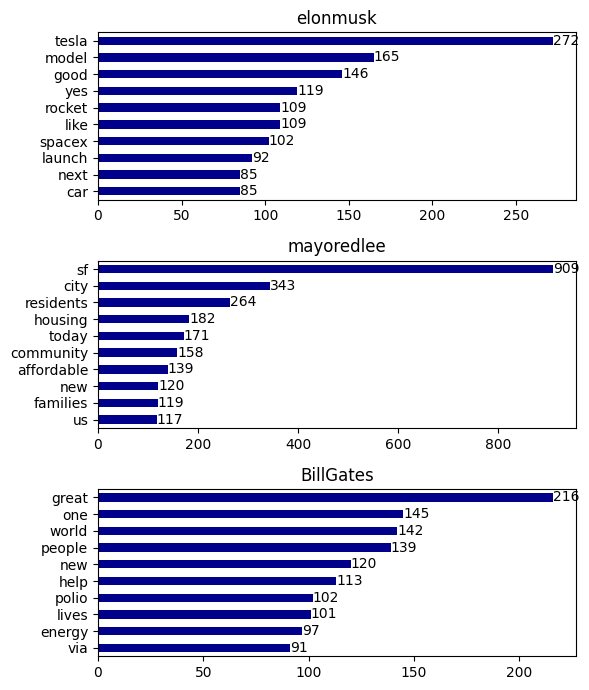

In [48]:
# Top 10 palabras más frecuentes por autor (excluyendo stopwords)

# Top 10 palabras por autor (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6, 7))

for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts = df_temp['token'].value_counts(ascending=False).head(10)
    bar_plot = counts.plot(kind='barh', color='darkblue', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

    for rect in bar_plot.containers:
        for idx, patch in enumerate(rect.patches):
            x = patch.get_width()
            y = patch.get_y() + patch.get_height() / 2
            bar_plot.text(x, y, f'{x:.0f}', ha='left', va='center')

fig.tight_layout()

El análisis de los resultados obtenidos permite observar que cada usuario analizado tiene un enfoque particular en su actividad profesional y eso se refleja en sus tweets.

* Ed Lee, en su calidad de alcalde de San Francisco, se enfoca en temas relacionados con la ciudad, sus residentes, familias y hogares.

* Elon Musk, como líder de empresas tecnológicas como Tesla y SpaceX, se enfoca en temas relacionados con la tecnología, los automóviles y la aeronáutica.

* Bill Gates, quien además de ser el propietario de Microsoft, tiene una fuerte dedicación a las fundaciones de ayuda, como se puede inferir de sus tweets relacionados con el mundo, la polio y la ayuda.

En general, se puede decir que los resultados son consistentes con las áreas de especialización de cada usuario y el enfoque de su actividad profesional, ahora ¿qué podemos ir analizando nosotros?, será posible formular ideas e hipótesis a partir de:

* ¿La relación con los tweets del alcalde de San Francisco?
* ¿Cuál es el enfoque principal de los tweets de Elon Musk?
* ¿En qué ámbito se enfocan los esfuerzos filantrópicos de Bill Gates?

## Análisis de la correlación entre los 3 de los muchos usuarios más influyentes de Twitter

Una forma eficaz de medir la similitud entre los perfiles de dos usuarios de Twitter es mediante el cálculo de la correlación en el uso de palabras. La premisa detrás de esta técnica es que dos usuarios que escriben de forma similar, usarán las mismas palabras con frecuencias similares. 

La medida de similitud más utilizada al trabajar con texto es 1 - distancia coseno. Para llevar a cabo este tipo de análisis, es fundamental contar con las variables adecuadamente organizadas en columnas. En este caso, las variables a correlacionar son los autores de los tweets.

In [40]:
# Análisis de datos a través de la técnica de pivoteo

tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None

In [42]:
# Análisis de similitud en el uso y frecuencia de palabras mediante test de correlación (coseno)
# 
from scipy.spatial.distance import cosine

def similitud_coseno(a,b):
    distancia = cosine(a,b)
    return 1-distancia

tweets_pivot.corr(method=similitud_coseno)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.567274,0.496346
elonmusk,0.567274,1.000000,0.276732
mayoredlee,0.496346,0.276732,1.000000


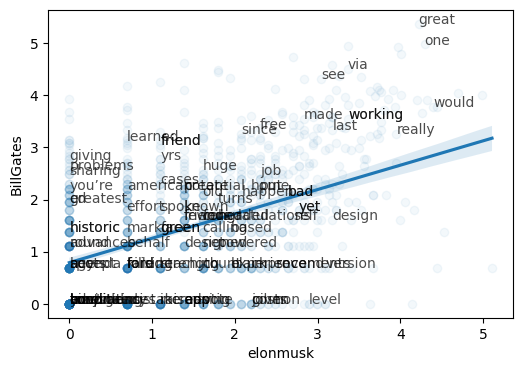

In [43]:
# Gráfico de correlación de palabras entre usuarios de Twitter

f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elonmusk),
    y  = np.log(temp.BillGates),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.elonmusk[i]), np.log(temp.BillGates[i])),
        alpha = 0.7
    )

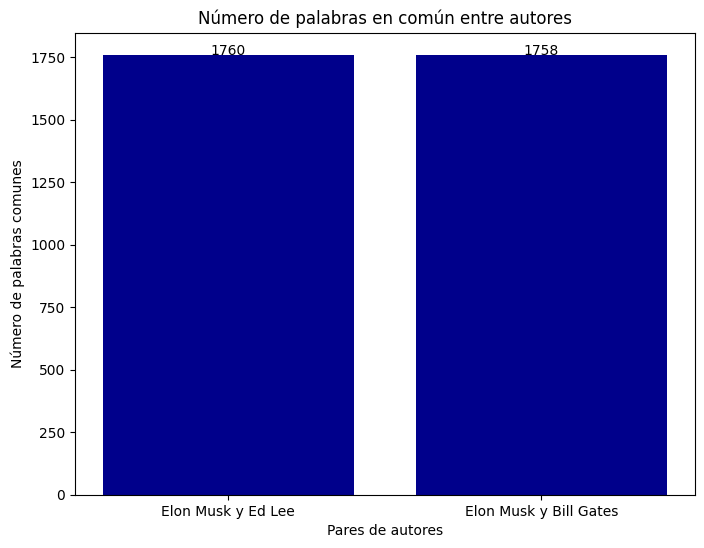

In [53]:
# Análisis del número de palabras en común entre dos textos

# Creamos una lista con las etiquetas de cada autor
autores = ['Elon Musk y Ed Lee', 'Elon Musk y Bill Gates']

# Creamos una lista con el número de palabras comunes entre cada par de autores
num_palabras = [len(palabras_elon.intersection(palabras_edlee)), 
                len(palabras_elon.intersection(palabras_bill))]

# Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Creamos la gráfica de barras
ax.bar(autores, num_palabras, color='darkblue')

# Añadimos los títulos y etiquetas del eje x e y
ax.set_title('Número de palabras en común entre autores')
ax.set_xlabel('Pares de autores')
ax.set_ylabel('Número de palabras comunes')

# Añadimos los valores en la parte superior de las barras
for i, v in enumerate(num_palabras):
    ax.text(i, v + 0.5, str(v), ha='center')

# Mostramos la gráfica
plt.show()

Aunque la cantidad de palabras compartidas entre Elon Musk y Bill Gates, y entre Elon Musk y Ed Lee es similar, la correlación basada en su uso es más significativa entre Elon Musk y Bill Gates. Esta observación puede ser explicada por el hecho de que ambos son líderes de empresas tecnológicas, lo que sugiere que comparten un conjunto de ideas y lenguaje especializados en ese campo. Por lo tanto, la correlación no solo depende del número de palabras compartidas, sino también de su contexto y significado en un ámbito particular.

## Mejora esta linea de texto: Comparación en el uso de palabras

El siguiente análisis se centra en identificar las palabras que son utilizadas de manera más distintiva por cada usuario, es decir, aquellas palabras que son muy frecuentes en el discurso de un autor y no lo son en el del otro. Para llevar a cabo esta tarea, se utiliza el [logaritmo de la razón de probabilidades de las frecuencias](https://en.wikipedia.org/wiki/Odds_ratio). Esta comparación se realiza en pares, en este caso, se compara la escritura de Elon Musk con la de Mayor Ed Lee.

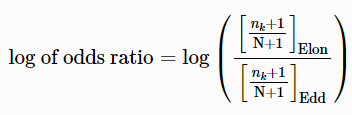

El cálculo se realiza utilizando la frecuencia de cada término en los textos de cada autor, siendo "nk" el número de veces que aparece el término "k" y "N" el número total de términos de cada autor. Para realizar este cálculo, es necesario cuantificar la frecuencia de cada palabra utilizada por todos los usuarios en el conjunto de tweets. En caso de que un autor no haya utilizado una palabra que otro sí ha utilizado, esa palabra debe aparecer en su registro con una frecuencia de cero. Existen diversas maneras de hacerlo, una de ellas es pivotar y despivotar el dataframe, reemplazando los valores NaN por cero.

In [54]:
# Cálculo del log of odds ratio de cada palabra (elonmusk vs mayoredlee)

# Pivotaje y despivotaje
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Selección de los autores elonmusk y mayoredlee
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['elonmusk', 'mayoredlee'])]

# Se añade el total de palabras de cada autor
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

# Cálculo de odds y log of odds de cada palabra
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.elonmusk/tweets_logOdds.mayoredlee)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# Si el logaritmo de odds es mayor que cero, significa que es una palabra con
# mayor probabilidad de ser de Elon Musk. Esto es así porque el ratio sea ha
# calculado como elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "elonmusk",
                                              "mayoredlee"
                                    )

In [55]:
print('-----------------------------------')
print('Top 10 palabras más diferenciadoras')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 palabras más diferenciadoras
-----------------------------------


,elonmusk,mayoredlee,log_odds,abs_log_odds,autor_frecuente
token,,,,,
tesla,0.012571,0.000037,5.815178,5.815178,elonmusk
residents,0.000046,0.009934,-5.374023,5.374023,mayoredlee
yes,0.005526,0.000037,4.993198,4.993198,elonmusk
rocket,0.005065,0.000037,4.906187,4.906187,elonmusk
community,0.000046,0.005960,-4.863198,4.863198,mayoredlee
spacex,0.004743,0.000037,4.840435,4.840435,elonmusk
sf,0.000276,0.034112,-4.815979,4.815979,mayoredlee
falcon,0.003776,0.000037,4.612426,4.612426,elonmusk
landing,0.003039,0.000037,4.395361,4.395361,elonmusk


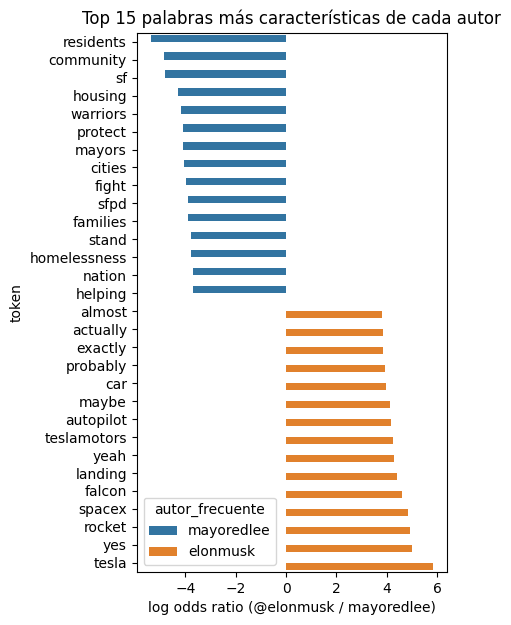

In [56]:
# Top 15 palabras más características de cada autor

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 palabras más características de cada autor')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

# Término Frecuencia e Inversa Documento Frecuencia

El análisis de textos conlleva el interés de cuantificar la temática de un documento, así como la importancia de cada término que lo conforma. Una manera simple de medir la relevancia de un término dentro de un documento es utilizar su frecuencia de aparición (tf, term-frequency). Sin embargo, esta aproximación tiene la limitación de otorgar demasiada importancia a palabras comunes que no aportan información relevante. Por ejemplo, si la palabra "página" aparece 50 veces en un documento y "matemáticas" solo 5, la primera tendrá un peso 10 veces mayor a pesar de que no es tan relevante para la temática del documento. Para solucionar esta problemática, se puede utilizar el estadístico tf-idf, que pondera los valores tf multiplicándolos por la inversa de la frecuencia con la que el término en cuestión aparece en otros documentos (idf). De esta manera, se reduce el valor de aquellos términos que aparecen con mucha frecuencia en muchos documentos y que, por ende, no aportan información relevante en la identificación de la temática del documento.

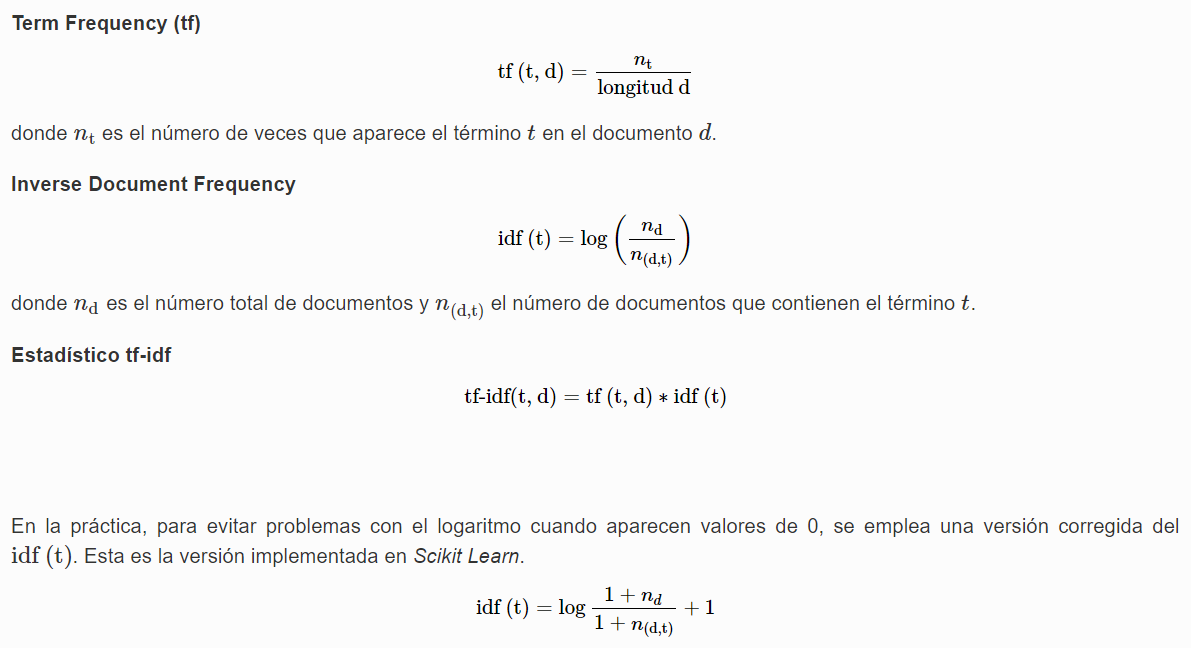

Se explicará cómo calcular el valor `tf-idf`. No obstante, en la práctica, resulta más conveniente utilizar herramientas implementadas, como el `TfidfVectorizer` de `Scikit Learn`.

In [57]:
# Cálculo term-frecuency (tf)

tf = tweets_tidy.copy()
# Número de veces que aparece cada término en cada tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,id,token,count,total_count,tf
8158,3.546906e+17,bar,1,20,0.05
8164,3.546906e+17,says,1,20,0.05
8166,3.546906e+17,walks,1,20,0.05


In [58]:
# Inverse document frequency

idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
50468,sf,914,2.061781
8724,city,355,3.007494
22820,great,327,3.089651


In [59]:
# Term Frequency - Inverse Document Frequency

tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,1.195196e+17,efforts,1,13,0.076923,31,5.445624,0.418894
46,1.195196e+17,job,1,13,0.076923,36,5.296093,0.407392
229,1.195196e+17,nigeria,1,13,0.076923,10,6.577027,0.505925
239,1.195196e+17,phenomenal,1,13,0.076923,14,6.240554,0.480043
253,1.195196e+17,polio,1,13,0.076923,102,4.254639,0.327280


Se puede apreciar que en el primer tweet (id = 1.195196e+17), todos los términos que aparecen una vez tienen el mismo valor de tf. No obstante, debido a que no todos los términos aparecen con la misma frecuencia en el conjunto de tweets, la corrección de idf varía para cada uno de ellos.

# Clasificación de tweets: una aproximación mediante análisis de sentimiento

Para poder aplicar algoritmos de clasificación a un texto, es imprescindible crear una representación numérica del mismo. Una de las técnicas más comunes es la denominada "Bag of Words". Este enfoque consiste en identificar el conjunto de todas las palabras (tokens) que aparecen en el corpus, es decir, el conjunto de todos los tweets recuperados, y crear un espacio n-dimensional en el que cada dimensión (columna) representa una palabra. A continuación, se proyecta cada texto en este espacio, asignando un valor para cada dimensión. En la mayoría de los casos, se utiliza el valor tf-idf.

A continuación se presenta un modelo de aprendizaje estadístico basado en máquinas de vector soporte (SVM) para predecir la autoría de los tweets de Elon Musk y Mayor Ed Lee.

El modelo se implementa utilizando la biblioteca `Scikit-Learn` y se utiliza la clase `TfidfVectorizer` para generar la matriz `TF-IDF`, utilizando el mismo tokenizador definido en secciones anteriores.

## División de datos en entrenamiento y prueba (Train-Test)

Mejora esta introducción: En los modelos de aprendizaje estadístico es necesario dividir los datos en un conjunto de entrenamiento y otro de prueba para evaluar la capacidad de generalización del modelo. En este ejercicio, se utilizará una proporción de 80/20 para el conjunto de entrenamiento y el conjunto de prueba, respectivamente.

In [60]:
# División de datos en conjuntos de entrenamiento y prueba

datos_X = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'texto']
datos_y = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'autor']

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

Es importante verificar que la proporción de cada grupo es similar en el set de entrenamiento y en el de test.

In [61]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'elonmusk': 52.68292682926829, 'mayoredlee': 47.31707317073171}
{'elonmusk': 50.53658536585366, 'mayoredlee': 49.46341463414634}


# Vectorización de texto con tf-idf

Utilizando los tweets de entrenamiento, se genera una matriz tf-idf en la que cada columna representa un término, cada fila corresponde a un documento y el valor de cada intersección es el tf-idf correspondiente. Esta matriz define un espacio n-dimensional en el cual se proyecta cada tweet.

La clase [TfidfVectorizer](https://bit.ly/2S6lwWP) de Scikit Learn permite crear de forma automática una matriz tf-idf a partir de un corpus de documentos. Algunos de los argumentos más destacados que se pueden especificar son:

* `encoding`: el tipo de codificación del texto, por defecto es 'utf-8'.

* `strip_accents`: eliminación de acentos sustituyendolos por la misma letra sin el acento. Por defecto se emplea el método ‘ascii’.

* `lowercase`: convertir a minúsculas todo el texto.

* `tokenizer`: en caso de querer pasar un tokenizador definido por el usuario o de otra librería.

* `analyzer`: tipo de división que realiza el tokenizador. Por defecto separa por palabras ('word').

* `stop_words`: lista de stopwords que se eliminan durante el tokenizado. Por defecto utiliza un listado para el inglés.

* `ngram_range`: rango de n-gramas incluidos. Por ejemplo, (1, 2) significa que se incluyen unigramas (palabras individuales) y bigramas (pares de palabras) como tokens.

* `min_df`: fracción o número de documentos en los que debe de aparecer como mínimo un término para no ser excluido en el tokenizado. Este filtrado es una forma de eliminar ruido del modelo.

In [62]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

In [63]:
stop_words = list(stopwords.words('english'))
# Se añade la stopword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))

In [64]:
# Creación de la matriz tf-idf

tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizador.fit(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function limpiar_tokenizar at 0x7f36253b5ee0>)

Es fundamental proyectar los documentos de test en la misma matriz obtenida previamente con los documentos de entrenamiento al realizar la transformación. Esto se debe a que si hay algún término en los documentos de test que no aparece en los de entrenamiento o viceversa, las dimensiones de cada matriz no coincidirán. Es decir, para que la transformación sea válida y los datos puedan ser utilizados en el modelo de aprendizaje, es necesario que las dimensiones de las matrices sean consistentes.

In [70]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

# Modelo de aprendizaje estadístico SVM lineal

In [78]:
# Entrenamiento del modelo SVM

modelo_svm_lineal = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_lineal.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [79]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# Se asigna el resultado a _ para que no se imprima por pantalla
_ = grid.fit(X = tfidf_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,0.967317,0.003123,0.997073,0.000366
5,0.278256,0.963902,0.001981,0.985244,0.000994
7,16.681005,0.959756,0.004154,0.998720,0.000122
8,129.154967,0.959024,0.005034,0.998780,0.000193
9,1000.0,0.959024,0.005034,0.998780,0.000193
4,0.035938,0.753902,0.013545,0.772683,0.006535
0,0.00001,0.526829,0.000000,0.526829,0.000000
1,0.000077,0.526829,0.000000,0.526829,0.000000
2,0.000599,0.526829,0.000000,0.526829,0.000000
3,0.004642,0.526829,0.000000,0.526829,0.000000


In [80]:
# Mejores hiperparámetros por validación cruzada

print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'C': 2.154434690031882} : 0.9673170731707316 accuracy


In [81]:
# Error predicciones test

predicciones_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Error de test")
print("-------------")

print(f"Número de clasificaciones erróneas de un total de {tfidf_test.shape[0]} " \
      f"clasificaciones: {(y_test != predicciones_test).sum()}"
)
print(f"% de error: {100*(y_test != predicciones_test).mean()}")

print("")
print("-------------------")
print("Matriz de confusión")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predicciones_test),
             columns= ["Elon Musk", "Mayor Ed Lee"],
             index = ["Elon Musk", "Mayor Ed Lee"])

-------------
Error de test
-------------
Número de clasificaciones erróneas de un total de 1025 clasificaciones: 21
% de error: 2.048780487804878

-------------------
Matriz de confusión
-------------------


,Elon Musk,Mayor Ed Lee
Elon Musk,512,6
Mayor Ed Lee,15,492


Utilizando un modelo de SVM lineal con un hiperparámetro de C=2.15, se logra obtener un error de prueba del 2.05%. Si bien este porcentaje de error es bastante bajo, es posible obtener resultados aún mejores explorando otros modelos, como SVM no lineales o Random Forest.

# Análisis de sentimientos en Twitter mediante SVM lineal y tf-idf.

Una forma común de analizar el sentimiento de un texto es mediante la suma de los sentimientos de cada una de las palabras que lo componen. Si bien esta no es la única forma de abordar el análisis de sentimientos, es una técnica que logra un buen equilibrio entre complejidad y resultados.

Para realizar este enfoque, se requiere contar con un diccionario que asocie a cada palabra un sentimiento o nivel de sentimiento. Estos diccionarios son conocidos como "sentiment lexicon". Entre los más utilizados se encuentran:

* AFINN: en él, se asigna a cada palabra un valor entre -5 y 5, siendo -5 el máximo de negatividad y +5 el máximo de positividad. Se puede acceder al diccionario a través del repositorio https://github.com/fnielsen/afinn/tree/master/afinn/data.

* Bing y Liu (http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar), donde las palabras están clasificadas como positivas o negativas.

In [82]:
# Descarga lexicon sentimientos

lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


## Cálculo del sentimiento promedio de cada tweet mediante análisis de sentimientos.

Al disponer de los datos en formato tidy (una palabra por fila), mediante un inner join se añade a cada palabra su sentimiento y se filtran automáticamente todas aquellas palabras para las que no hay información disponible.

In [83]:
# Sentimiento promedio de cada tweet
# ==============================================================================
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")

# Se suman los sentimientos de las palabras que forman cada tweet.
tweets_sentimientos = tweets_sentimientos[["autor","fecha", "id", "sentimiento"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_sentimientos.head()

,autor,fecha,id,sentimiento
0,BillGates,2011-09-29 21:11:15+00:00,1.195196e+17,6
1,BillGates,2011-10-04 19:06:05+00:00,1.213001e+17,-3
2,BillGates,2011-10-06 00:37:29+00:00,1.217459e+17,3
3,BillGates,2011-10-06 00:38:09+00:00,1.217460e+17,6
4,BillGates,2011-10-19 22:12:21+00:00,1.267828e+17,3


## Tweets positivos, negativos y neutros

In [84]:
def perfil_sentimientos(df):
    print(autor)
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")
    print(" ")

for autor, df in tweets_sentimientos.groupby("autor"):
    perfil_sentimientos(df)

BillGates
Positivos: 79.88
Neutros  : 4.59
Negativos: 15.52
 
elonmusk
Positivos: 73.14
Neutros  : 4.29
Negativos: 22.57
 
mayoredlee
Positivos: 80.73
Neutros  : 4.07
Negativos: 15.2
 


Los tres autores presentan un patrón de comportamiento similar en sus tweets, con una predominancia de expresiones positivas. Este fenómeno es común en las redes sociales, donde los usuarios suelen compartir experiencias positivas o aspectos destacables de su vida, omitiendo los aspectos negativos.

## Análisis de la evolución temporal del sentimiento promedio de los tweets de usuarios por intervalos mensuales.

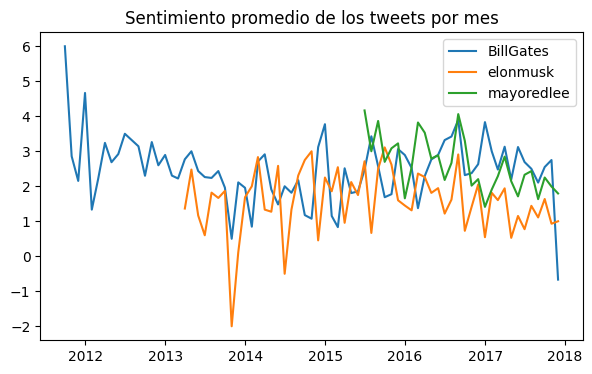

In [85]:
fig, ax = plt.subplots(figsize=(7, 4)) 

for autor in tweets_sentimientos.autor.unique():
    df = tweets_sentimientos[tweets_sentimientos.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['sentimiento']].resample('1M').mean()
    ax.plot(df.index, df.sentimiento, label=autor)

ax.set_title("Sentimiento promedio de los tweets por mes")
ax.legend();